In [1]:
import pandas as pd
mvc = pd.read_csv("nypd_mvc_2018.csv")
null_counts = mvc.isnull().sum()
null_counts

unique_key                 0
date                       0
time                       0
borough                20646
location                3885
on_street              13961
cross_street           29249
off_street             44093
pedestrians_injured        0
cyclist_injured            0
motorist_injured           0
total_injured              1
pedestrians_killed         0
cyclist_killed             0
motorist_killed            0
total_killed               5
vehicle_1                355
vehicle_2              12262
vehicle_3              54352
vehicle_4              57158
vehicle_5              57681
cause_vehicle_1          175
cause_vehicle_2         8692
cause_vehicle_3        54134
cause_vehicle_4        57111
cause_vehicle_5        57671
dtype: int64

In [2]:
killed_cols = [col for col in mvc.columns if 'killed' in col]
killed = mvc[killed_cols].copy()
killed_manual_sum = killed.iloc[:,:3].sum(axis=1)
killed_mask = killed_manual_sum != killed['total_killed']
killed_non_eq = killed[killed_mask]
killed_non_eq


,pedestrians_killed,cyclist_killed,motorist_killed,total_killed
3508,0,0,0,NaN
20163,0,0,0,NaN
22046,0,0,1,0.0
48719,0,0,0,NaN
55148,0,0,0,NaN
55699,0,0,0,NaN


# Mask

In [3]:
import numpy as np

# fix the killed values
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'].isnull(), killed_manual_sum)
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'] != killed_manual_sum, np.nan)

# Create an injured dataframe and manually sum values
injured = mvc[[col for col in mvc.columns if 'injured' in col]].copy()
injured_manual_sum = injured.iloc[:,:3].sum(axis=1)
injured['total_injured'] = injured['total_injured'].mask(injured['total_injured'].isnull(), injured_manual_sum)
injured['total_injured'] = injured['total_injured'].mask(injured['total_injured'] != injured_manual_sum, np.nan)

In [4]:
summary = {
    'injured': [
        mvc['total_injured'].isnull().sum(),
        injured['total_injured'].isnull().sum()
    ],
    'killed': [
        mvc['total_killed'].isnull().sum(),
        killed['total_killed'].isnull().sum()
    ]
}
print(pd.DataFrame(summary, index=['before','after']))


mvc['total_injured'] = injured['total_injured']
mvc['total_killed'] = killed['total_killed']

        injured  killed
before        1       5
after        21       1


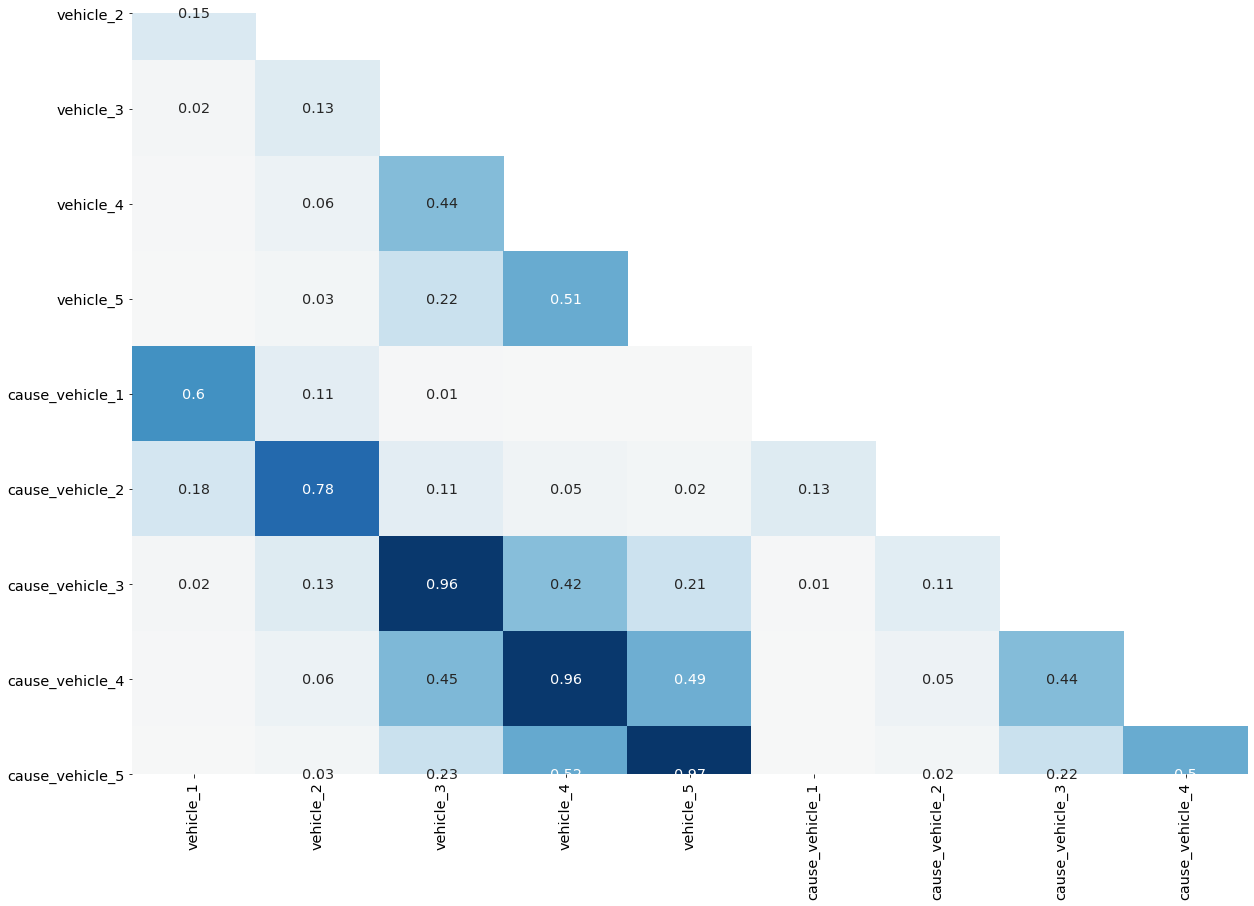

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_null_correlations(df):
    # create a correlation matrix only for columns with at least
    # one missing value
    cols_with_missing_vals = df.columns[df.isnull().sum() > 0]
    missing_corr = df[cols_with_missing_vals].isnull().corr()
    
    # create a triangular mask to avoid repeated values and make
    # the plot easier to read
    missing_corr = missing_corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(missing_corr), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(missing_corr, vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()
    
vehicle_cols = [col for col in mvc.columns if 'vehicle' in col]
temp_df = mvc[vehicle_cols]
plot_null_correlations(temp_df)

In [7]:
col_labels = ['v_number', 'vehicle_missing', 'cause_missing']

vc_null_data = []

for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    
    v_null = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
    c_null = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()
    
    vc_null_data.append([v, v_null, c_null])

vc_null_df = pd.DataFrame(vc_null_data, columns=col_labels)
vc_null_df

,v_number,vehicle_missing,cause_missing
0,1,204,24
1,2,3793,223
2,3,242,24
3,4,50,3
4,5,10,0


# STACK

In [8]:
v_cols = [c for c in mvc.columns if c.startswith("vehicle")]
df = mvc[v_cols]
df1 = df.stack()
vehicles_counts =  df1.value_counts()
top10_vehicles = vehicles_counts.head(10)
top10_vehicles

Sedan                                  33133
Station Wagon/Sport Utility Vehicle    26124
PASSENGER VEHICLE                      16026
SPORT UTILITY / STATION WAGON          12356
Taxi                                    3482
Pick-up Truck                           2373
TAXI                                    1892
Box Truck                               1659
Bike                                    1190
Bus                                     1162
dtype: int64

In [10]:
def summarize_missing():
    v_missing_data = []

    for v in range(1,6):
        v_col = 'vehicle_{}'.format(v)
        c_col = 'cause_vehicle_{}'.format(v)

        v_missing = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
        c_missing = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()

        v_missing_data.append([v, v_missing, c_missing])

    col_labels = columns=["vehicle_number", "vehicle_missing", "cause_missing"]
    return pd.DataFrame(v_missing_data, columns=col_labels)

summary_before = summarize_missing()

for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    
    v_missing_mask = (mvc[v_col].isnull() & mvc[c_col].notnull())
    c_missing_mask = (mvc[c_col].isnull() & mvc[v_col].notnull())
    
    mvc[v_col] = mvc[v_col].mask(v_missing_mask, "Unspecified")
    mvc[c_col] = mvc[c_col].mask(c_missing_mask, "Unspecified")
    
summary_after = summarize_missing()
summary_after

,vehicle_number,vehicle_missing,cause_missing
0,1,0,0
1,2,0,0
2,3,0,0
3,4,0,0
4,5,0,0


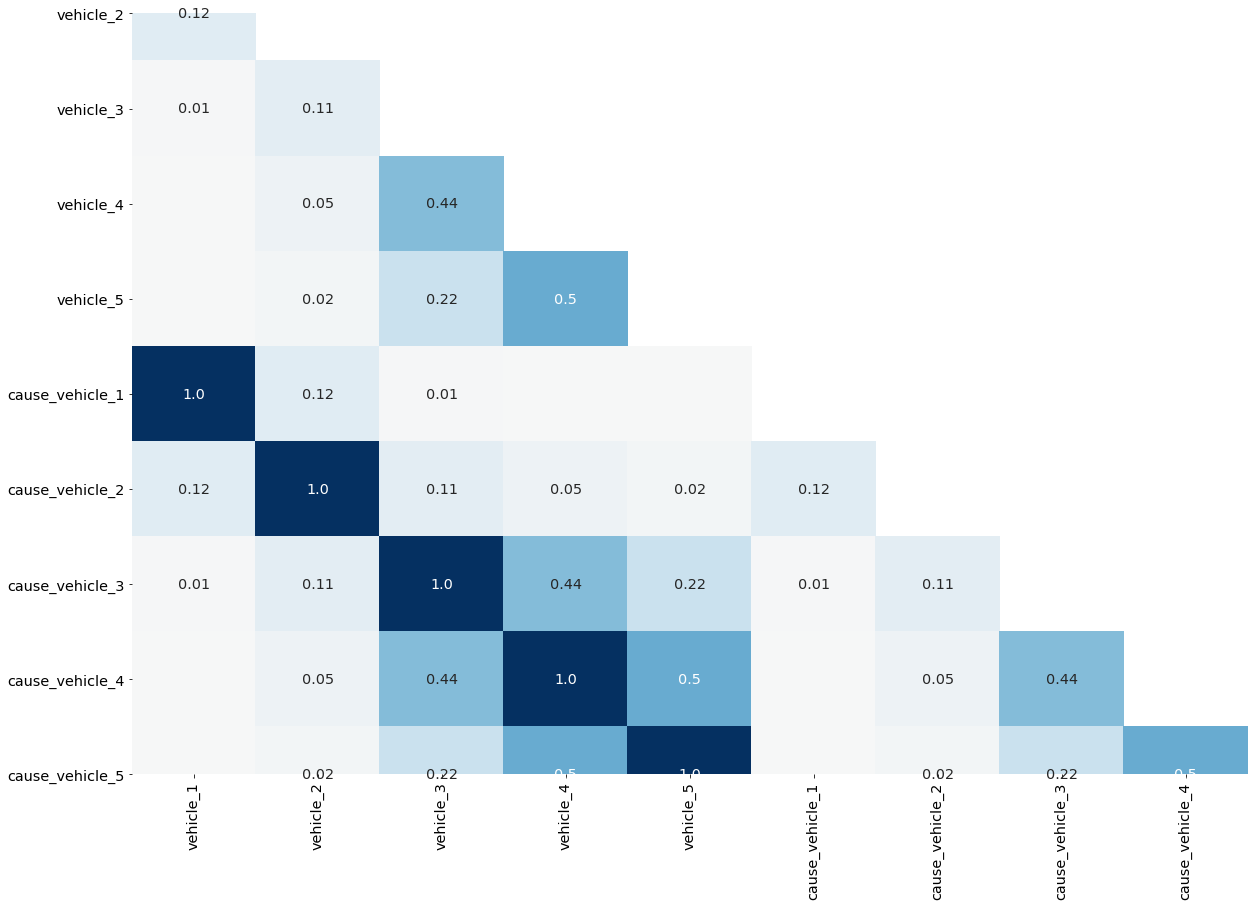

In [11]:
veh_cols = [c for c in mvc.columns if 'vehicle' in c]
plot_null_correlations(mvc[veh_cols])

In [12]:
loc_cols = ['borough', 'location', 'on_street', 'off_street', 'cross_street']
location_data = mvc[loc_cols]
print(location_data.head())

     borough                location                         on_street  \
0  MANHATTAN  (40.742832, -74.00771)  WEST 15 STREET                     
1   BROOKLYN  (40.623714, -73.99314)  16 AVENUE                          
2        NaN   (40.591755, -73.9083)  BELT PARKWAY                       
3     QUEENS   (40.73602, -73.87954)  GRAND AVENUE                       
4      BRONX  (40.884727, -73.89945)                               NaN   

                                 off_street    cross_street  
0                                       NaN       10 AVENUE  
1                                       NaN       62 STREET  
2                                       NaN             NaN  
3                                       NaN  VANLOON STREET  
4  208       WEST 238 STREET                            NaN  


In [13]:
print(location_data.isnull().sum())

borough         20646
location         3885
on_street       13961
off_street      44093
cross_street    29249
dtype: int64


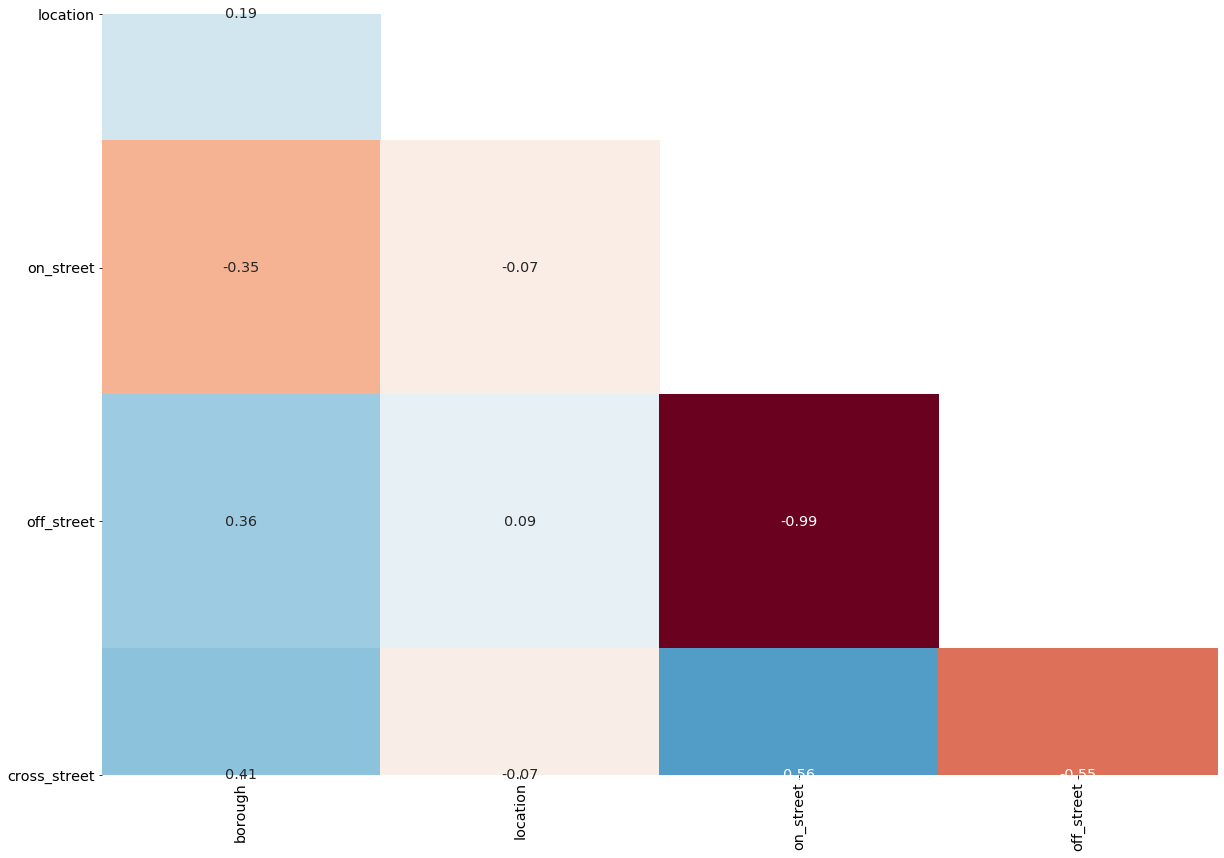

In [14]:
plot_null_correlations(location_data)

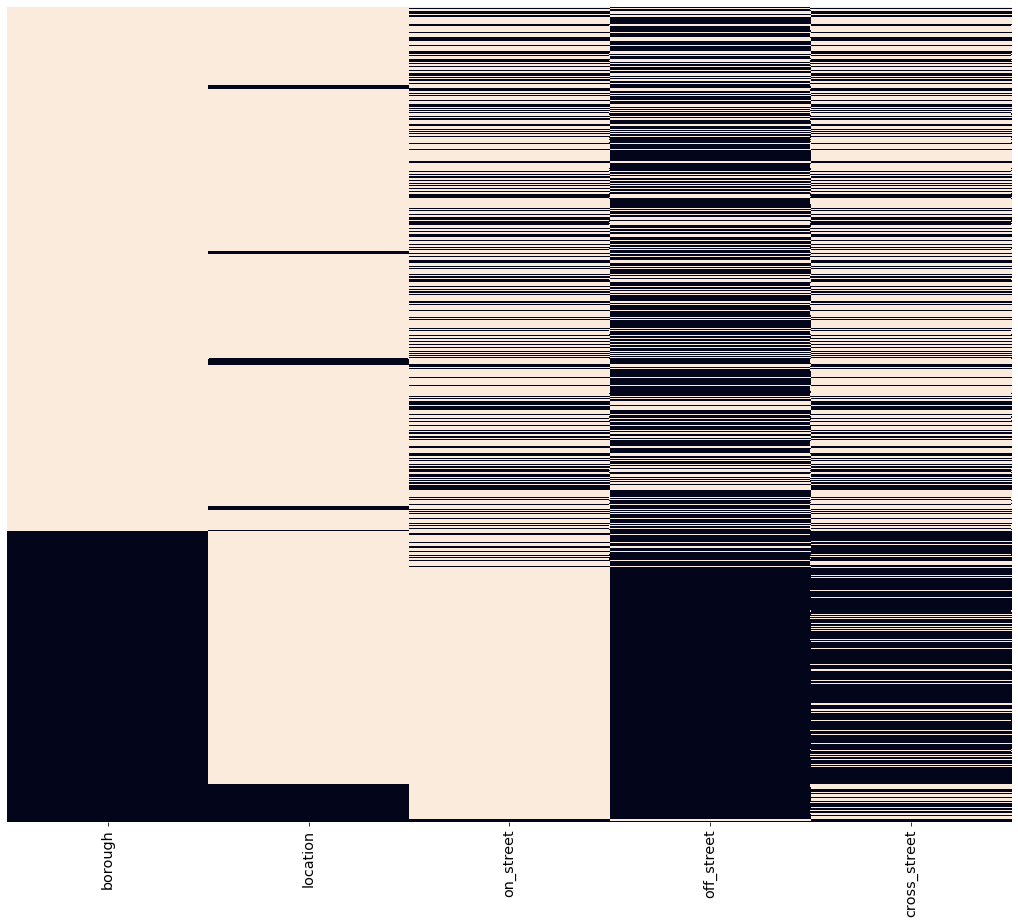

In [16]:
def plot_null_matrix(df, figsize=(18,15)):
    # initiate the figure
    plt.figure(figsize=figsize)
    # create a boolean dataframe based on whether values are null
    df_null = df.isnull()
    # create a heatmap of the boolean dataframe
    sns.heatmap(~df_null, cbar=False, yticklabels=False)
    plt.xticks(rotation=90, size='x-large')
    plt.show()


sorted_location_data = location_data.sort_values(loc_cols)
plot_null_matrix(sorted_location_data)

In [18]:
sup_data = pd.read_csv('supplemental_data.csv')
sup_data.head()

mvc_keys = mvc['unique_key']
sup_keys = sup_data['unique_key']

is_equal = mvc_keys.equals(sup_keys)
print(is_equal)

True


In [19]:

sup_data = pd.read_csv('supplemental_data.csv')

location_cols = ['location', 'on_street', 'off_street', 'borough']
null_before = mvc[location_cols].isnull().sum()


for col in location_cols:
        
    mask = mvc[col].isnull()
    mvc[col] = mvc[col].mask(mask, sup_data[col])
   
    
null_after = mvc[location_cols].isnull().sum()

print(null_before)
print(null_after)

location       3885
on_street     13961
off_street    44093
borough       20646
dtype: int64
location         77
on_street     13734
off_street    36131
borough         232
dtype: int64


,unique_key,date,time,borough,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,...,vehicle_1,vehicle_2,vehicle_3,vehicle_4,vehicle_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
0,3869058,2018-03-23,21:40,MANHATTAN,"(40.742832, -74.00771)",WEST 15 STREET,10 AVENUE,NaN,0,0,...,PASSENGER VEHICLE,Unspecified,NaN,NaN,NaN,Following Too Closely,Unspecified,NaN,NaN,NaN
1,3847947,2018-02-13,14:45,BROOKLYN,"(40.623714, -73.99314)",16 AVENUE,62 STREET,NaN,0,0,...,SPORT UTILITY / STATION WAGON,DS,NaN,NaN,NaN,Backing Unsafely,Unspecified,NaN,NaN,NaN
2,3914294,2018-06-04,0:00,BROOKLYN,"(40.591755, -73.9083)",BELT PARKWAY,NaN,NaN,0,0,...,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,Following Too Closely,Unspecified,NaN,NaN,NaN
3,3915069,2018-06-05,6:36,QUEENS,"(40.73602, -73.87954)",GRAND AVENUE,VANLOON STREET,NaN,0,0,...,Sedan,Sedan,NaN,NaN,NaN,Glare,Passing Too Closely,NaN,NaN,NaN
4,3923123,2018-06-16,15:45,BRONX,"(40.884727, -73.89945)",NaN,NaN,208 WEST 238 STREET,0,0,...,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,Turning Improperly,Unspecified,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57859,3835191,2018-01-26,14:51,BRONX,"(40.85477, -73.90299)",CRESTON AVENUE,EAST 181 STREET,NaN,3,0,...,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,Unspecified,NaN,NaN,NaN,NaN
57860,3890674,2018-04-29,18:30,QUEENS,"(40.78419, -73.84582)",COLLEGE POINT BOULEVARD,15 AVENUE,NaN,0,0,...,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,Backing Unsafely,Unspecified,NaN,NaN,NaN
57861,3946458,2018-07-21,16:45,MANHATTAN,"(40.711926, -74.0061)",PARK ROW,NaN,40 PARK ROW,0,0,...,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,Turning Improperly,Unspecified,NaN,NaN,NaN
57862,3914574,2018-06-04,5:45,BROOKLYN,"(40.71976, -73.94476)",BROOKLYN QUEENS EXPRESSWAY,NaN,NaN,0,0,...,Sedan,Tractor Truck Diesel,Station Wagon/Sport Utility Vehicle,NaN,NaN,Other Vehicular,Unspecified,Unspecified,NaN,NaN
